In [2]:
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

import shap
import joblib

In [3]:
DATA_DIR = Path("../data/processed")
ARTIFACT_DIR = Path("../model")

batsman_df = pd.read_csv(DATA_DIR / "batsman_model_data.csv", parse_dates=["date"])
pipeline = joblib.load(ARTIFACT_DIR / "feature_pipeline_batsman.pkl")

print("Dataset shape:", batsman_df.shape)

Dataset shape: (15842, 13)


In [4]:
split_date = "2023-01-01"

train_df = batsman_df[batsman_df["date"] < split_date]
test_df  = batsman_df[batsman_df["date"] >= split_date]

target = "runs_next_match"

drop_cols = ["match_id", "date", "batter", target]

X_train = train_df.drop(columns=drop_cols)
y_train = train_df[target]

X_test = test_df.drop(columns=drop_cols)
y_test = test_df[target]

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (13789, 9)
Test shape: (2053, 9)


In [5]:
X_train_p = pipeline.transform(X_train)
X_test_p  = pipeline.transform(X_test)

feature_names = pipeline.get_feature_names_out()

In [6]:
baseline_pred = test_df["runs_avg_last_10"].fillna(
    test_df["runs_avg_last_10"].mean()
)

baseline_mae = mean_absolute_error(y_test, baseline_pred)
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_pred))
baseline_r2 = r2_score(y_test, baseline_pred)

print("Baseline Performance")
print("MAE :", baseline_mae)
print("RMSE:", baseline_rmse)
print("R2  :", baseline_r2)

Baseline Performance
MAE : 16.99104813706616
RMSE: 22.605654386274363
R2  : 0.041136104684815766


In [7]:
rf = RandomForestRegressor(
    n_estimators=150,
    max_depth=10,
    min_samples_leaf=15,
    max_features="sqrt",
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train_p, y_train)

rf_pred = rf.predict(X_test_p)

rf_mae = mean_absolute_error(y_test, rf_pred)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
rf_r2 = r2_score(y_test, rf_pred)

print("Random Forest")
print("MAE :", rf_mae)
print("RMSE:", rf_rmse)
print("R2  :", rf_r2)

Random Forest
MAE : 16.502743875707388
RMSE: 21.94519799760038
R2  : 0.09634676769539297


In [8]:
xgb = XGBRegressor(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)

xgb.fit(X_train_p, y_train)

xgb_pred = xgb.predict(X_test_p)

xgb_mae = mean_absolute_error(y_test, xgb_pred)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
xgb_r2 = r2_score(y_test, xgb_pred)

print("XGBoost")
print("MAE :", xgb_mae)
print("RMSE:", xgb_rmse)
print("R2  :", xgb_r2)

XGBoost
MAE : 16.801017762275656
RMSE: 22.418783608158403
R2  : 0.05692357306628393


In [9]:
lgb = LGBMRegressor(
    n_estimators=400,
    learning_rate=0.05,
    random_state=42
)

lgb.fit(X_train_p, y_train)

lgb_pred = lgb.predict(X_test_p)

lgb_mae = mean_absolute_error(y_test, lgb_pred)
lgb_rmse = np.sqrt(mean_squared_error(y_test, lgb_pred))
lgb_r2 = r2_score(y_test, lgb_pred)

print("LightGBM")
print("MAE :", lgb_mae)
print("RMSE:", lgb_rmse)
print("R2  :", lgb_r2)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000785 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1666
[LightGBM] [Info] Number of data points in the train set: 13789, number of used features: 74
[LightGBM] [Info] Start training from score 20.045544
LightGBM
MAE : 16.78932046914825
RMSE: 22.274540801397343
R2  : 0.06902007011051126


X does not have valid feature names, but LGBMRegressor was fitted with feature names


In [10]:
param_grid = {
    "n_estimators": [300, 400],
    "max_depth": [5, 6],
    "learning_rate": [0.03, 0.05]
}

grid = GridSearchCV(
    XGBRegressor(objective="reg:squarederror", random_state=42),
    param_grid,
    cv=3,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train_p, y_train)

best_xgb = grid.best_estimator_

print("Best Parameters:", grid.best_params_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Parameters: {'learning_rate': 0.03, 'max_depth': 5, 'n_estimators': 300}


In [11]:
results = pd.DataFrame({
    "Model": ["Baseline", "Random Forest", "XGBoost", "LightGBM"],
    "MAE": [baseline_mae, rf_mae, xgb_mae, lgb_mae],
    "RMSE": [baseline_rmse, rf_rmse, xgb_rmse, lgb_rmse],
    "R2": [baseline_r2, rf_r2, xgb_r2, lgb_r2]
})

results.sort_values("RMSE")

,Model,MAE,RMSE,R2
1,Random Forest,16.502744,21.945198,0.096347
3,LightGBM,16.789320,22.274541,0.069020
2,XGBoost,16.801018,22.418784,0.056924
0,Baseline,16.991048,22.605654,0.041136


In [12]:
sample_size = 2000

sample_idx = np.random.choice(
    X_train_p.shape[0],
    sample_size,
    replace=False
)

X_shap_sample = X_train_p[sample_idx]

# Convert ONLY small sample to dense
if hasattr(X_shap_sample, "toarray"):
    X_shap_sample = X_shap_sample.toarray()

explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_shap_sample)

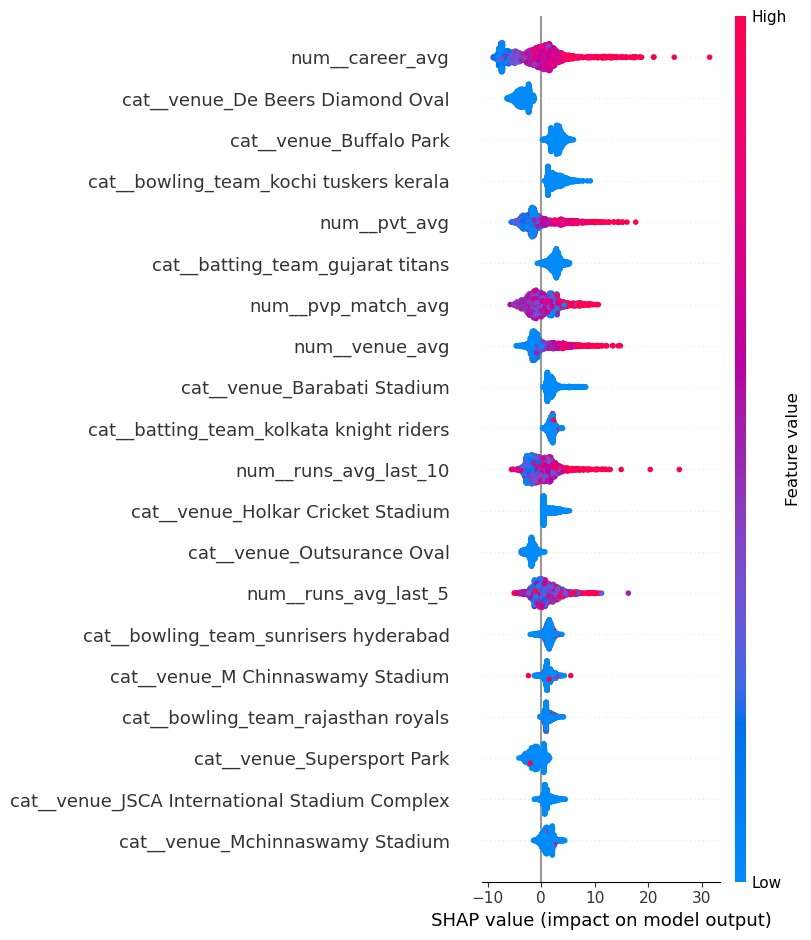

In [13]:
shap.summary_plot(
    shap_values,
    X_shap_sample,
    feature_names=feature_names
)

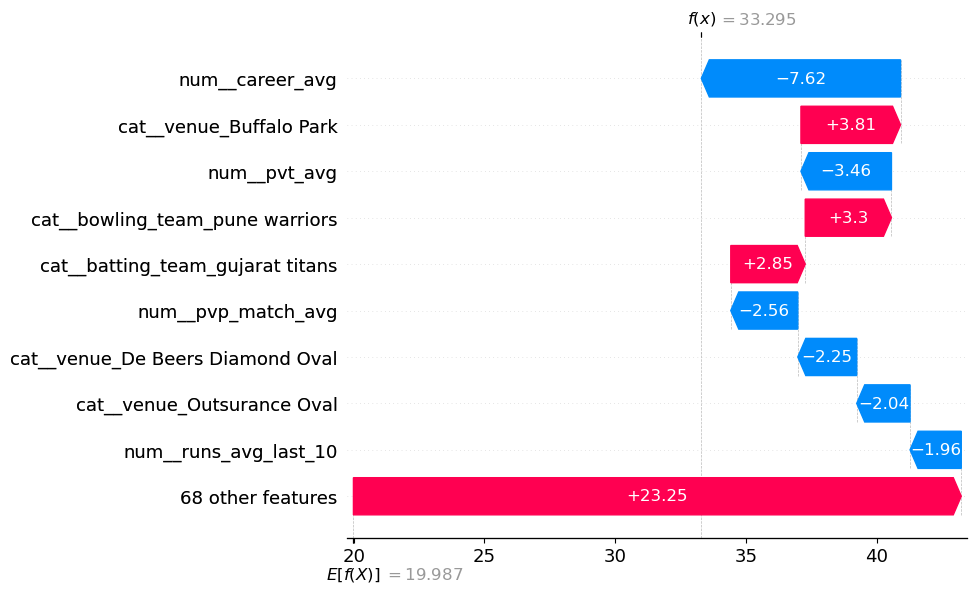

In [14]:
shap.plots._waterfall.waterfall_legacy(
    explainer.expected_value,
    shap_values[0],
    feature_names=feature_names
)

In [15]:
joblib.dump(xgb, ARTIFACT_DIR / "xgb_batsman_model.joblib")

print("✅ xgb_batsman_model.joblib saved successfully")

✅ xgb_batsman_model.joblib saved successfully


In [16]:
# Extract numeric feature names from pipeline
num_features = pipeline.transformers_[0][2]

print("Numeric engineered features:")
print(num_features)

Numeric engineered features:
['runs_avg_last_5', 'runs_avg_last_10', 'career_avg', 'venue_avg', 'pvt_avg', 'pvp_match_avg']


In [17]:
X_train_p = pipeline.transform(X_train)

In [18]:
sample_size = 2000

sample_idx = np.random.choice(
    X_train_p.shape[0],
    sample_size,
    replace=False
)

X_sample = X_train_p[sample_idx]

In [19]:
if hasattr(X_sample, "toarray"):
    X_sample = X_sample.toarray()

In [20]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_sample)

In [21]:
feature_names = pipeline.get_feature_names_out()

# Get positions of numeric engineered features
num_feature_indices = [
    i for i, f in enumerate(feature_names)
    if any(nf in f for nf in num_features)
]

X_numeric = X_sample[:, num_feature_indices]
shap_numeric = shap_values[:, num_feature_indices]

numeric_feature_names = feature_names[num_feature_indices]

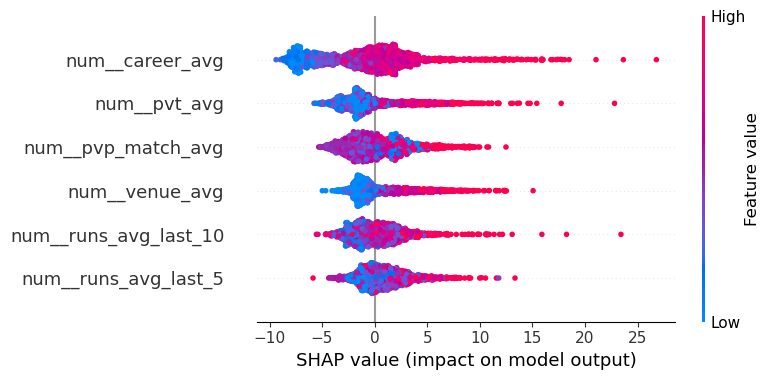

In [22]:
shap.summary_plot(
    shap_numeric,
    X_numeric,
    feature_names=numeric_feature_names
)

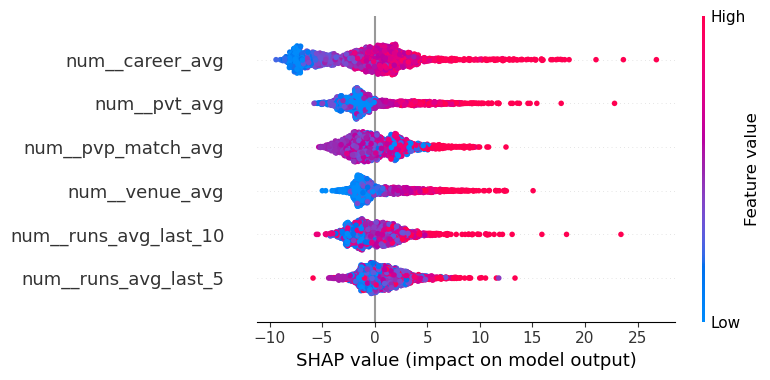

In [23]:
shap.summary_plot(
    shap_numeric,
    X_numeric,
    feature_names=numeric_feature_names,
    max_display=6
)

In [24]:
residuals = y_val - model.predict(X_val)
residual_std = np.std(residuals)

print(residual_std)

NameError: name 'y_val' is not defined